# CausalML Lecture 5: Heterogeneous Treatment Effect

_"The average causal effect T is an _average_ and as such enjoys all the advantages and disadvantages of averages." – P. W. Holland_

**Giorgio Coppola**  
**Xiaohan Wu**

---

## Setup Instructions

To replicate this environment and run this notebook with the exact same package versions using poetry like in Lecture 1:

1. **Install dependencies**:
   ```bash
   poetry install
   ```
   This will create a virtual environment and install all dependencies specified in `pyproject.toml`. Learn more about [dependency management](https://python-poetry.org/docs/dependency-specification/).

2. **Create and install the Jupyter kernel**:
   ```bash
   poetry run python -m ipykernel install --user --name=lecture-5-env --display-name="CausalML Lecture 5"
   ```
   The `poetry run` command executes commands within the Poetry virtual environment. See [Poetry environment management](https://python-poetry.org/docs/managing-environments/).

3. **Start Jupyter**:
   ```bash
   poetry run jupyter notebook
   ```

4. **Select the kernel**: In Jupyter, go to Kernel → Change Kernel → "CausalML Lecture 5"

For more information about Poetry and its features, visit the [official Poetry documentation](https://python-poetry.org/docs/).

---

## Quick recap form Lecture 5 and previous  

#### Until now, we **focused on the ATE** in experimental or nonrandomized observational settings, using **global information!**  

For this, **modeling (including ML) helps:** we can adjust for pre-treatment covariates, balance with weights, or do both. These approaches help because they **exploit covariates information to approximate missing counterfactuals** and to implement the assumption of conditional ignorability when it’s plausible.  

- In **experimental settings,** ignorability holds by design; covariate adjustment mainly improves precision (and can mitigate sample imbalance and noncompliance), while weighting rebalances covariates to address observed selection bias when randomization fails (if we have overlap). Doubly robust estimators combine outcome and treatment models and are consistent if either is correctly specified.  

- In **observational settings,** identification relies on **conditional ignorability** given selected pre-treatment covariates (plus overlap and SUTVA). Models and weights (or both), if they are correctly specified, can help replace the assumption of independence with a less stringent conditional version, yielding to a consistent ATE.  

#### **With HTE, this is harder:** we need local information, but **local information is scarce!**   

We want to estimate a **causal effect that vary across units**. Problem: we cannot make causal claims about specific individuals with certainty!  

When estimating HTE, we are interested in **ITE or CATE conditional on groups defined by X**. We cannot estimate ITE, but CATE is a compromise. However, as X-defined groups get finer, we can lose overlap locally, we don't have sufficient treatment and control units for each X-defined groups &rarr; **curse of dimensionality**.

As **we don't have an observable target** (counterfactual), we don't have a natural loss function and a validation set. This means that the HTE true signal that an estimator can estimate is small relative to the noise, and naïve ML approaches like "T-learners" or "S-learners" are prone to high variance/overfitting. They usually mistake prognostic signal (features that predict baseline risk) and treatment assignment signal (propensity) for causal moderation (the features that change how much treatment effect vary): in some situations, you might highlight **spurious heterogeneity**.

The challenge is **recover CATEs without chasing noise** and report uncertainty that’s credible. 
To do so, we need methods that build a valid loss with orthogonal/pseudo-outcomes and cross-fitting like 

- **causal forests**,
- **X-learners**, and
- **DR-learners**,  

so we can target CATE τ(x), rather than modeling the outcome Y alone.  

We are going to show some of them, and how they can help!

---


# Simulation Plan: HTE Estimation

## Aims  

Show, via a Monte Carlo simulation, that:  

1. **Naïve ML for HTE (S/T-learners)** mostly learns prognosis or amplifies noise.   
2. **Causal Forests** (Wager–Athey, 2018) recover heterogeneity and enable inference when overlap is decent.  
3. **Meta-learners (X-learner)** (Künzel et al., 2019; Kennedy, 2020) recover heterogeneity also with imbalance.  

---

## Data Generating Mechanism  

We simulate two scenarios:  

- **Balanced treatment assignment** across covariates $X$.  
- **Imbalanced assignment** to make things **worse**.

**Setup:**  

- **Covariates:** Ten features give enough complexity for prognosis and treatment effect to depend on different things.  
  _Actually we only use 7 in the DGP, and we use the rest for noise_
  $$
  X = (X_1, \dots, X_{10}) \sim \mathcal{N}(0,1).
  $$  
- **Potential outcomes** with some noise: 
  $$
  Y(0) = \mu(X) + \varepsilon, \quad 
  Y(1) = \mu(X) + \tau(X) + \varepsilon, \quad 
  \varepsilon \sim \mathcal{N}(0,1).
  $$  
- **Baseline outcome (prognosis):** We add nonlinearities & interactions.  
  If $\mu(X)$ (prognosis) is large/complex and $\tau(X)$ is modest, the best way to reduce squared error is to learn $\mu(X)$ very well. This is what naïve learners do: nothing in the loss forces them to isolate $\tau(X)$.
  $$
  \mu(x) = 2\sin(X_1) + 1.25X_2 + 1.5\mathbf{1}\{X_3>0\} + 0.75X_4X_5 + |X_6|
  $$  
- **True treatment effect (CATE):** We add moderation.  
  $\tau$ depends partly on the same variables as $\mu$ (e.g., $X1$,$X3$) but not in the same way, and also on regions of $X2$. This creates moderation.
  $$
  \tau(x) = 1 + 1.12\mathbf\{X_1>0\} - 1.12\mathbf\{X_2>1\} + \sin(X_7/2), \quad 
  \tau(x) \in [-2.5, 2.5].
  $$  
- **Treatment assignment:**  
  - *Balanced:* propensities near 0.5 with little X-dependence.  
    $$
    e(x) = \sigma(-0.1 + 0.13X_1 - 0.13X_3 + 0.1X_6)
    $$  
  - *Imbalanced:* units have high or low propensities.
That creates regions with few controls or few treated, and it's useful to show the limitation and streght of methods.
    $$
    e(x) = \sigma( -1.2 + 1.0X_1 + 0.8X_3 + 0.6X_6)
    $$  
  - $ A \sim \text{Bernoulli}(e(x)) $.  

---

## Assumptions  

- **Conditional ignorability:**  $Y(a) \perp A \mid X$  
- **Overlap:**  $0 < P(A=1 \mid X) < 1$  
- **SUTVA:** Stable unit treatment values, no interference.  

---

## Estimands  

- **CATE:** $ \tau(x) $ evaluated on test set.  
- **ATE:** $ \mathbb{E}[\tau(X)] $ to check if our CATE $ \tau(x) $ integrates to the right average effect.

---

## Methods  

**Baselines:**  
- **S-learner:** one outcome model $ m(a,x) $, $ \tau(x) = m(1,x) − m(0,x)$.  
- **T-learner:** separate outcome models by arm, subtract predictions.  

**"Solutions":**  
- **Causal Forest** (Wager–Athey, 2018).  
- **X-learner** (Künzel et al., 2019) with tree base models.  
- _(If we manage)_ **DR-learner** (Kennedy, 2020).  

---

## Performance Metrics

- **Mean Integrated Squared Error (MISE)**: integrates the pointwise error over the distribution of $X$ to give a single global number.
$$
\text{MISE} = \mathbb{E}_{X}\left[(\hat{\tau}(X) - \tau(X))^2\right]
$$

- **ATE recovery:** compare $ \hat{\text{ATE}} = \mathbb{E}[\hat{\tau}(x)] $ vs. true ATE.
  Even if pointwise CATEs are noisy, we shouldn’t miss the average effect badly. If $\hat{ATE}$ is far from $ATE_{True}$ , the model is systematically biased.
  
- **Scatter plot:** compare $\hat{\tau}(x)$ vs. true $\tau(x)$.

- **Calibration plots:**  
Do high predicted CATEs correspond to actually larger realized effects?    
  - Bin units by predicted CATE ($\hat{\tau}(x)$).  
  - X-axis = average predicted CATE in bin.  
  - Y-axis = realized treatment effect in bin.
     
---

## Simulation

We will simulate data and test methods under condition different conditions. 

### Expected Results

- **Balanced assignment:** S/T-learners capture prognosis, not treatment effect; poor calibration. Causal Forest and X-learner align more closely with true CATE.  
- **Imbalanced assignment:** S/T degrade further (follow propensity & prognosis). X-learner helps under imbalance.  
- **Key lesson:** Without orthogonalization and overlap, naïve ML misleads us about heterogeneity.  

### Setup environment


In [14]:
import numpy as np
import pandas as pd
import plotnine as p9
from plotnine import (
    ggplot, aes, geom_histogram, geom_density, geom_point, geom_line,
    geom_vline, labs, theme, theme_minimal
)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
mean_squared_error, mean_absolute_error, r2_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
GradientBoostingRegressor, RandomForestRegressor, RandomForestClassifier,
)

from econml.metalearners import XLearner
from econml.dml import CausalForestDML

p9.theme_set(theme_minimal() + theme(legend_position="bottom"))
sns.set_theme(style="whitegrid")

import warnings
warnings.filterwarnings('ignore')        

np.random.seed(12345)

## Data Generation for HTE 

We define:
- Function for prognosis (mu)
- Function for true HTE (tao)
- Function for treatment assignment (propensity)
- Function to simulate the population
  

In [27]:
# helper
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

# defining the true parameter
def mu_func(X):
    """
    Baseline prognosis μ(x) with nonlinearities & interactions:
    """
    x1, x2, x3, x4, x5, x6 = X[:,0], X[:,1], X[:,2], X[:,3], X[:,4], X[:,5]
    return 2*np.sin(x1) + 1.25*x2 + 1.5*(x3 > 0).astype(float) + 0.75*x4*x5 + np.abs(x6) 

def tau_func(X):
    """
    True CATE τ(x):
    """
    x1, x2, x3 = X[:,0], X[:,1], X[:,2]
    tau = 1 + 1.12*(x1 > 0).astype(float) - 1.12*(x2 > 1).astype(float) + np.sin(x3/2)
    return np.clip(tau, -2.5, 2.5)

def propensity(X, scenario="balanced"):
    x1, x3, x6 = X[:,0], X[:,2], X[:,5]
    if scenario == "balanced":
        logits = -0.1 + 0.13*x1 - 0.13*x3 + 0.1*x6  
    elif scenario == "imbalanced":
        logits = -1.2 + 1.0*x1 + 0.8*x3 + 0.6*x6  
    else:
        raise ValueError("scenario must be 'balanced' or 'imbalanced'")
    return sigmoid(logits)

# defining the population simulator 
def simulate_htedgp(n=600, scenario="balanced", noise_sd=1.0, seed=12345, 
                    tau_function=None, mu_function=None, prop_function=None):
    """
    Draw X ~ N(0,1)^10, compute μ, τ, propensities e(X), treatment A ~ Bernoulli(e),
    and observed Y = μ + A*τ + ε with ε ~ N(0, noise_sd^2).

    You can optionally pass custom functions:
      - tau_function(X)
      - mu_function(X)
      - prop_function(X, scenario)
    Otherwise uses defaults defined in the environment.
    """
    # use defaults if not supplied
    if mu_function is None:
        mu_function = mu_func
    if tau_function is None:
        tau_function = tau_func
    if prop_function is None:
        prop_function = propensity

    rng = np.random.default_rng(seed)
    X = rng.normal(size=(n, 10))
    mu = mu_function(X)
    tau = tau_function(X)
    e = prop_function(X, scenario=scenario)
    A = rng.binomial(1, e, size=n)
    eps = rng.normal(0, noise_sd, size=n)
    Y = mu + A * tau + eps
    y0_true = mu
    y1_true = mu + tau

    df = pd.DataFrame({f"X{j+1}": X[:, j] for j in range(10)})
    df["mu_true"] = mu
    df["tau_true"] = tau
    df["e_true"] = e
    df["A"] = A
    df["eps"] = eps
    df["Y"] = Y
    df["y0_true"] = y0_true
    df["y1_true"] = y1_true
    df["scenario"] = scenario
    df.attrs["true_ate"] = float(np.mean(tau))
    return df


## Exploration

### Properties of the population

We will first examine fixed properties of the population and visualize them.

In [28]:
# params
N = 10000
SCENARIO = "balanced" # balanced or imbalanced

df = simulate_htedgp(n=N, scenario=SCENARIO)

# properties
print("True ATE:", df.attrs["true_ate"])
print("P(A=1):", df["A"].mean())

# overlap diagnostic
good_overlap = df["e_true"].between(0.05, 0.95).mean()
print("Share with e(x) in [0.05,0.95]:", round(good_overlap, 3))


True ATE: 1.3671412030039447
P(A=1): 0.4729
Share with e(x) in [0.05,0.95]: 1.0


### Plots

We define a bunch of functions for visuals.

In [29]:
def plot_overlap(df, e_col="e_true", t_col="A"):
    tmp = df[[e_col, t_col]].copy()
    tmp["arm"] = np.where(tmp[t_col].astype(int) == 1, "T=1", "T=0")

    plt.figure(figsize=(7, 4.5))
    ax = sns.histplot(
        data=tmp, x=e_col, hue="arm",
        bins=30, stat="density", common_norm=False, alpha=0.5
    )
    ax.axvline(0.05, linestyle="--", linewidth=1, color="black")
    ax.axvline(0.95, linestyle="--", linewidth=1, color="black")
    ax.set(xlim=(0, 1), xlabel="Propensity score e(X)", ylabel="Density",
           title="Do We Have Overlap? Propensity by Treatment")
    plt.tight_layout()
    plt.show()


def plot_true_tau_heat(
    df,
    x1_col="X1",
    x2_col="X2",
    x3_col="X3",
    grid_points=150,
    sample_points=2000,
    x3_fixed="median",
):
    """
    Visualizes the *true* τ(x) over (X1, X2) with X3 fixed.
    - Uses the current Matplotlib default colormap to match your original imshow.
    - Removes numeric tick values from axes (keeps axis labels).
    """
    x1 = df[x1_col].to_numpy()
    x2 = df[x2_col].to_numpy()
    x3 = df[x3_col].to_numpy()
    T  = df["A"].to_numpy().astype(int)

    # grid over observed support for x1, x2
    x1min, x1max = np.quantile(x1, [0.01, 0.99])
    x2min, x2max = np.quantile(x2, [0.01, 0.99])
    gx1 = np.linspace(x1min, x1max, grid_points)
    gx2 = np.linspace(x2min, x2max, grid_points)
    X1, X2 = np.meshgrid(gx1, gx2)

    # choose X3 level
    if x3_fixed == "median":
        x3_val = float(np.median(x3))
    elif isinstance(x3_fixed, (int, float)):
        x3_val = float(x3_fixed)
    else:
        raise ValueError("x3_fixed must be 'median' or a numeric value.")

    # τ = 1 + 0.8*1{X1>0} - 0.8*1{X2>1} + sin(X3/2), clipped
    tau_grid = 1 + 0.8*(X1 > 0).astype(float) - 0.8*(X2 > 1).astype(float) + np.sin(x3_val/2.0)
    tau_grid = np.clip(tau_grid, -2.5, 2.5)
    vmax = float(np.max(np.abs(tau_grid)))

    # seaborn heatmap expects a 2D array/DF with row/col labels
    tau_df = pd.DataFrame(tau_grid, index=gx2, columns=gx1)

    fig, ax = plt.subplots(figsize=(7, 5.5))
    sns.heatmap(
        tau_df,
        cmap=plt.get_cmap(),     
        vmin=-vmax, vmax=vmax,
        cbar_kws={"label": "True CATE τ(X1, X2)  (X3 fixed)"},
        ax=ax
    )
    # put low X2 at bottom (Cartesian orientation)
    ax.invert_yaxis()

    # overlay a light sample of observed support (treated vs control)
    n = len(x1)
    k = min(sample_points, n)
    rng = np.random.default_rng(0)
    idx = rng.choice(n, size=k, replace=False)
    ctl = idx[T[idx] == 0]
    trt = idx[T[idx] == 1]

    # map (x1,x2) to heatmap index space
    def to_col_idx(vals):
        return np.interp(vals, (gx1[0], gx1[-1]), (0, grid_points - 1)) + 0.5
    def to_row_idx(vals):
        return np.interp(vals, (gx2[0], gx2[-1]), (0, grid_points - 1)) + 0.5

    x1_ctl_ix = to_col_idx(x1[ctl]); x2_ctl_ix = to_row_idx(x2[ctl])
    x1_trt_ix = to_col_idx(x1[trt]); x2_trt_ix = to_row_idx(x2[trt])

    sns.scatterplot(x=x1_ctl_ix, y=x2_ctl_ix, s=10, alpha=0.35, marker="o",
                    edgecolor=None, label="Control", ax=ax)
    sns.scatterplot(x=x1_trt_ix, y=x2_trt_ix, s=14, alpha=0.35, marker="^",
                    edgecolor=None, label="Treated", ax=ax)

    # remove numeric tick values (keep axis labels)
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_xticklabels([]); ax.set_yticklabels([])

    ax.set_xlabel("X1 (drives τ via 1{X1>0})")
    ax.set_ylabel("X2 (drives τ via 1{X2>1})")
    ax.set_title("Where Effects Live: True CATE τ(X1, X2) with Data Support")
    plt.tight_layout()
    plt.show()

df = df.assign(Control=df["y0_true"], Treatment=df["y1_true"])

def plot_po_distrib(df):
    po_long = df.melt(value_vars=["Treatment", "Control"],
                      var_name="Potential", value_name="y")
    plt.figure(figsize=(7, 4.5))
    ax = sns.kdeplot(data=po_long, x="y", hue="Potential",
                     fill=True, alpha=0.35, common_norm=False)
    ax.set(xlabel="Outcome (noise-free)", ylabel="Density",
           title="Distributions: Treatment vs Control")
    plt.tight_layout()
    plt.show()

def _binned_po(df, var="X1", nbins=40):
    b = pd.qcut(df[var], nbins, duplicates="drop")
    g = (df.groupby(b, observed=True)
           .agg({var: "mean", "Treatment": "mean", "Control": "mean"})
           .reset_index(drop=True))
    return g.melt(id_vars=var, value_vars=["Treatment", "Control"],
                  var_name="Potential", value_name="y")

def plot_po_binned_vs_x(df, var="X1", nbins=40, title=None):
    dat = _binned_po(df, var=var, nbins=nbins)
    plt.figure(figsize=(7, 4.5))
    ax = sns.lineplot(data=dat, x=var, y="y", hue="Potential")
    ax.set(xlabel=var,
           ylabel=f"E[Y(a) | {var}-bin]",
           title=title or f"Binned means: Treatment vs Control across {var}")
    plt.tight_layout()
    plt.show()


#### Figures explanation

**Figure 1** visualizes the overlap.

**Figure 2** visualizes the true CATE from the simulated data: effects increase when $X1>0$, decrease when $X2>1$, and are shifted smoothly by $X3$ (here $X3$ is fixed so we see a clean 2-D slice). The vertical $(X1=0)$ and horizontal $(X2=1)$ lines are the DGP’s indicator thresholds, causing the sharp jumps in color (positive = benefit, negative = harm).

**Figure 3** visualizes the distributions of the potential outcomes $Y(0)$ and $Y(1)$.

**Figure 4, 5, 6** visualizes treatment and control across $X1$, $X2$ and $X3$

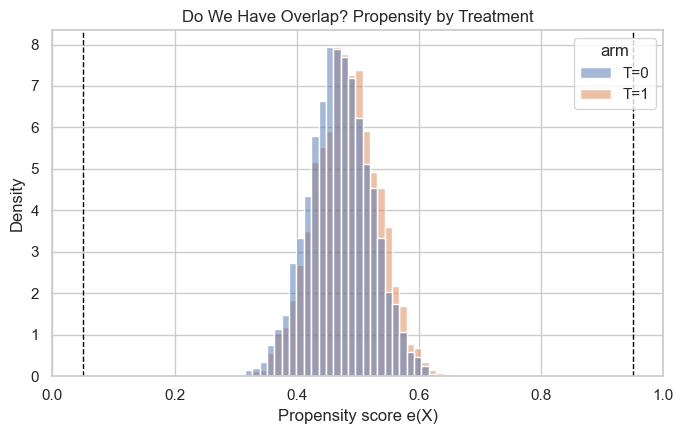

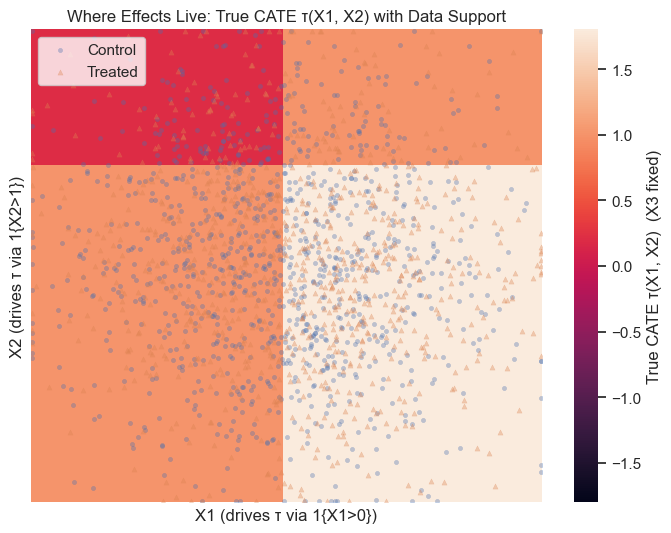

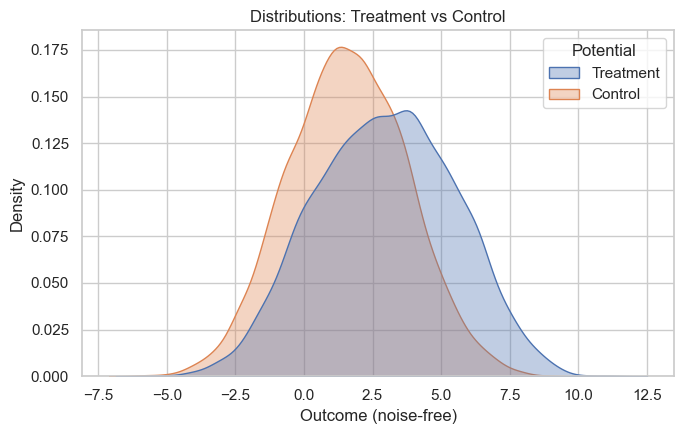

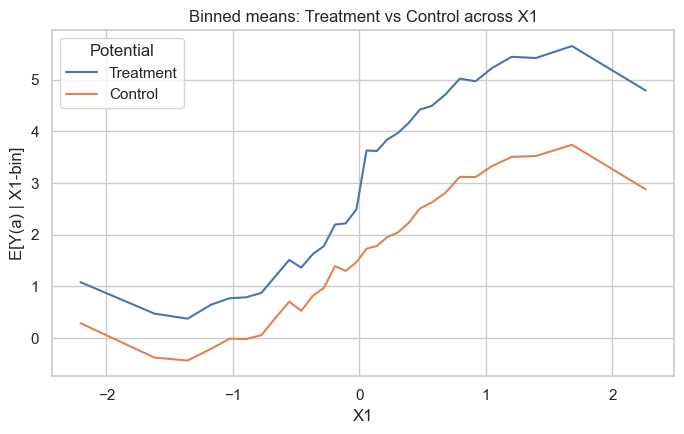

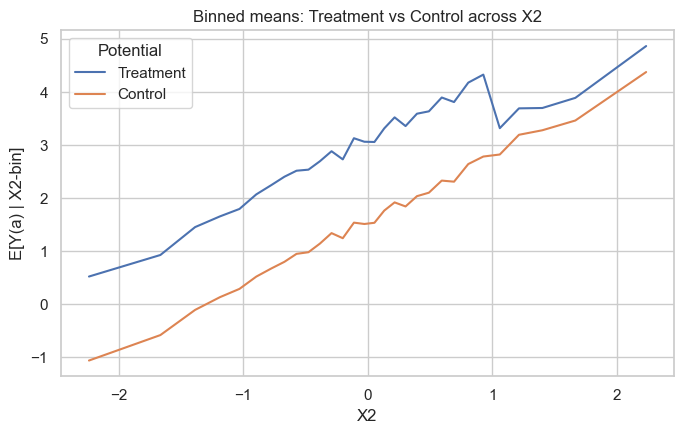

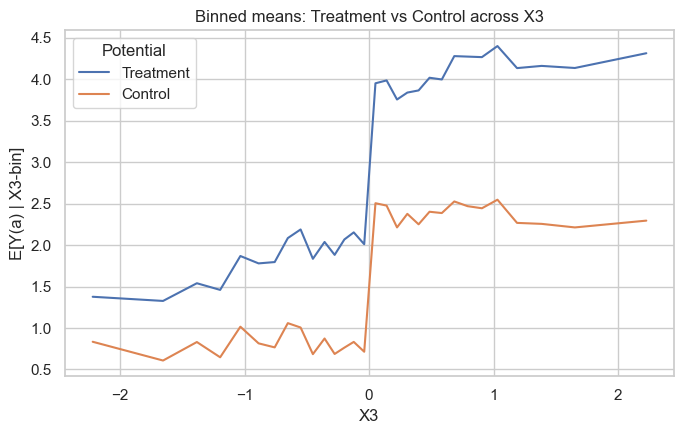

In [30]:
plot_overlap(df)                                  
plot_true_tau_heat(df, x3_fixed="median")    
plot_po_distrib(df)
plot_po_binned_vs_x(df, var="X1", nbins=30)
plot_po_binned_vs_x(df, var="X2", nbins=30)
plot_po_binned_vs_x(df, var="X3", nbins=30)


## HTE Estimation: Naïve approach.

We will implement **S-** and **T-learners**, evaluate them against the true CATE, and give diagnostics that show when and why they don't perform optimally: in a situation where high variance prognosis and propensity dominate the moderation effect, they might fail.

#### Define functions

In [31]:
## Train-test data
def split_train_test(df, test_size=0.33, seed=123):
    cols_keep = [c for c in df.columns]  # keep all columns, we'll pick features later
    d = df[cols_keep].copy()
    return train_test_split(d, test_size=test_size, random_state=seed)

def get_X(df, feature_cols):
    return df[feature_cols].to_numpy()

## Define S-learner and T-learner
# S-learner
def s_learner_tau(train_df, test_df, feature_cols, base=None):
    if base is None:
        base = GradientBoostingRegressor(random_state=1)
    Xtr = get_X(train_df, feature_cols)
    Atr = train_df["A"].to_numpy()
    Ytr = train_df["Y"].to_numpy()
    model = base
    # One model on (A, X)
    XA = np.c_[Atr, Xtr]
    model.fit(XA, Ytr)
    Xte = get_X(test_df, feature_cols)
    tau_hat = model.predict(np.c_[np.ones(len(Xte)), Xte]) - model.predict(np.c_[np.zeros(len(Xte)), Xte])
    return tau_hat

# T-learner 
def t_learner_tau(train_df, test_df, feature_cols, base_t=None, base_c=None):
    if base_t is None: base_t = GradientBoostingRegressor(random_state=2)
    if base_c is None: base_c = GradientBoostingRegressor(random_state=3)
    Xtr = get_X(train_df, feature_cols)
    Atr = train_df["A"].to_numpy().astype(bool)
    Ytr = train_df["Y"].to_numpy()
    Mt, Mc = base_t, base_c
    # Separate models by arm
    Mt.fit(Xtr[Atr], Ytr[Atr])
    Mc.fit(Xtr[~Atr], Ytr[~Atr])
    Xte = get_X(test_df, feature_cols)
    return Mt.predict(Xte) - Mc.predict(Xte)

## Evaluation: numbers + diagnostics that show mislearning 
# Pointwise comparison to TRUE CATE 
def compare_to_truth(test_df, tau_hat, include_chasing=True):
    tau_true = test_df["tau_true"].to_numpy()
    out = {
        "MISE": float(mean_squared_error(tau_true, tau_hat)),     # = empirical global risk
        "corr(tau_hat, tau_true)": float(np.corrcoef(tau_true, tau_hat)[0,1]),
        "ATE_hat": float(np.mean(tau_hat)),
        "ATE_true": float(np.mean(tau_true)),
    }
    if include_chasing:
        mu_true = test_df["mu_true"].to_numpy()
        e_true  = test_df["e_true"].to_numpy()
        out["corr(tau_hat, mu_true)"] = float(np.corrcoef(tau_hat, mu_true)[0,1]) # shows whether the learner mistakes outcome levels for treatment effects
        out["corr(tau_hat, e_true)"]  = float(np.corrcoef(tau_hat, e_true)[0,1]) # shows whether the learner is confounded by treatment assignment
    return out

# Oracle calibration: predicted-bin mean vs TRUE-bin mean 
def oracle_calibration_df(test_df, tau_hat, q=10):
    d = test_df.copy()
    d["tau_hat"] = tau_hat
    d["bin"] = pd.qcut(d["tau_hat"], q=q, duplicates="drop")
    g = d.groupby("bin", observed=True)
    return pd.DataFrame({
        "pred_bin_mean": g["tau_hat"].mean().values,
        "true_bin_mean": g["tau_true"].mean().values
    })


### How Naïve models perform

We used only 7 features in the DGP: 3 are noise and used to create misspecified models.

In [37]:
# params
N = 10000
SCENARIO = "balanced" # or "imbalanced"

df = simulate_htedgp(n=N, scenario=SCENARIO)

# Feature sets
FEATURES_CORE = [f"X{i}" for i in range(1, 7)]   # X1..X6 (the ones used in DGP)
FEATURES_ALL  = [f"X{i}" for i in range(1, 11)]  # X1..X10 (adds irrelevant X7..X10)
FEATURES = FEATURES_ALL 

# Fit learners
train_df, test_df = split_train_test(df, test_size=0.33, seed=1)

tau_s = s_learner_tau(train_df, test_df, FEATURES)
tau_t = t_learner_tau(train_df, test_df, FEATURES)

,Model,MISE,"corr(tau_hat, tau_true)",ATE_hat,ATE_true,"corr(tau_hat, mu_true)","corr(tau_hat, e_true)"
0,Baseline (τ̄),0.620,NaN,1.374,1.374,NaN,NaN
1,S-learner,0.144,0.883,1.296,1.374,0.390,0.167
2,T-learner,0.218,0.846,1.358,1.374,0.292,0.115


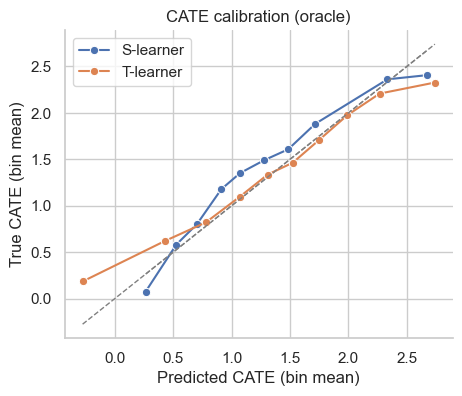

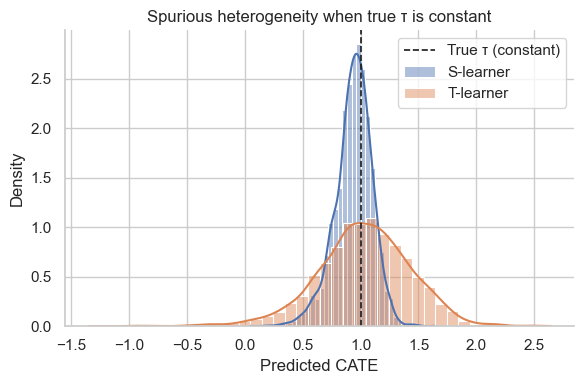

Std. dev. of predicted CATE — S: 0.161, T: 0.407.  True τ variance: 0.000


In [38]:
# Table: global error + bias + ranking
tbl = pd.DataFrame([
    {"Model":"Baseline (τ̄)", **compare_to_truth(test_df, np.full(len(test_df), float(test_df["tau_true"].mean())), include_chasing=False)},
    {"Model":"S-learner",    **compare_to_truth(test_df, tau_s)},
    {"Model":"T-learner",    **compare_to_truth(test_df, tau_t)},
])
tbl = tbl.round(3)
display(tbl)

# Oracle calibration overlay (true-bin mean vs predicted-bin mean)
def plot_oracle_calibration(test_df, tau_hat, label, q=10, ax=None):
    cal = oracle_calibration_df(test_df, tau_hat, q=q)
    if ax is None: fig, ax = plt.subplots(figsize=(5,4))
    sns.lineplot(data=cal, x="pred_bin_mean", y="true_bin_mean", marker="o", ax=ax, label=label)
    lo, hi = cal["pred_bin_mean"].min(), cal["pred_bin_mean"].max()
    ax.plot([lo,hi],[lo,hi], linestyle="--", linewidth=1, color="gray")
    ax.set_xlabel("Predicted CATE (bin mean)")
    ax.set_ylabel("True CATE (bin mean)")
    ax.set_title("CATE calibration (oracle)")
    sns.despine()
    return ax

def plot_spurious_when_constant_tau(test_df_c, tau_s_c, tau_t_c, bins=40, title=None):
    """
    Visualizes spurious heterogeneity when the true τ is constant:
    overlays the predicted CATE distributions from S/T learners and
    marks the true τ with a vertical line.
    """
    true_tau = float(test_df_c["tau_true"].mean())
    if title is None:
        title = "Spurious heterogeneity when true τ is constant"

    fig, ax = plt.subplots(figsize=(6,4))
    sns.histplot(tau_s_c, bins=bins, kde=True, stat="density", label="S-learner", alpha=0.45, ax=ax)
    sns.histplot(tau_t_c, bins=bins, kde=True, stat="density", label="T-learner", alpha=0.45, ax=ax)

    ax.axvline(true_tau, color="k", linestyle="--", linewidth=1.2, label="True τ (constant)")
    ax.set_xlabel("Predicted CATE")
    ax.set_ylabel("Density")
    ax.set_title(title)
    ax.legend()
    sns.despine()
    plt.tight_layout()
    plt.show()

    # (Optional) quick numeric summary to underscore the point
    s_sd = np.std(tau_s_c)
    t_sd = np.std(tau_t_c)
    print(f"Std. dev. of predicted CATE — S: {s_sd:.3f}, T: {t_sd:.3f}.  True τ variance: 0.000")

# Simulate data with constant treatment effect
def tau_constant(X): return np.full(X.shape[0], 1.0)

df_c = simulate_htedgp(n=N, scenario=SCENARIO, tau_function=tau_constant)
train_df_c, test_df_c = split_train_test(df_c, test_size=0.33, seed=2)

tau_s_c = s_learner_tau(train_df_c, test_df_c, FEATURES)
tau_t_c = t_learner_tau(train_df_c, test_df_c, FEATURES)

ax = plot_oracle_calibration(test_df, tau_s, "S-learner", q=10)
plot_oracle_calibration(test_df, tau_t, "T-learner", q=10, ax=ax)
plot_spurious_when_constant_tau(test_df_c, tau_s_c, tau_t_c)

In [39]:
print("n treated:", train_df["A"].sum())
print("n control:", (~train_df["A"].astype(bool)).sum())

n treated: 3201
n control: 3499


---

## HTE Estimation: Causal Forest and X-Learner.


#### Define X learner

In [40]:
def x_learner_econml_tau(train_df, test_df, feature_cols, base="rf",
                         n_estimators=300, min_leaf=5, random_state=10):
    """
    Returns tau_hat on test_df using econml's XLearner.
    Uses a simple logistic regression for propensity g(x).
    """
    Xtr = train_df[feature_cols].to_numpy()
    Wtr = train_df["A"].to_numpy().astype(int)
    Ytr = train_df["Y"].to_numpy()
    Xte = test_df[feature_cols].to_numpy()

    if base == "rf":
        base_model = RandomForestRegressor(
            n_estimators=n_estimators, min_samples_leaf=min_leaf,
            random_state=random_state, n_jobs=-1
        )
    elif base == "gbr":
        base_model = GradientBoostingRegressor(random_state=random_state)
    else:
        raise ValueError("base must be 'rf' or 'gbr'")

    xlearner = XLearner(
        models=base_model,                # μ0, μ1 base models
        cate_models=base_model,           # τ0, τ1 base models
        propensity_model=LogisticRegression(max_iter=1000, solver="lbfgs")
    )
    xlearner.fit(Ytr, Wtr, X=Xtr)
    tau_hat = xlearner.effect(Xte)
    return tau_hat


#### Define Causal Forest

In [41]:
def causal_forest_tau(
    train_df, test_df, feature_cols,
    n_trees=500, min_leaf=5, random_state=123,
    base_y="rf", want_ci=True
):
    # features / labels
    Xtr = train_df[feature_cols].to_numpy()
    Wtr = train_df["A"].to_numpy().astype(int)
    Ytr = train_df["Y"].to_numpy()
    Xte = test_df[feature_cols].to_numpy()

    # nuisance models
    if base_y == "rf":
        model_y = RandomForestRegressor(
            n_estimators=200, min_samples_leaf=5, random_state=random_state, n_jobs=-1
        )
    else:
        from sklearn.ensemble import GradientBoostingRegressor
        model_y = GradientBoostingRegressor(random_state=random_state)

    model_t = LogisticRegression(max_iter=1000, solver="lbfgs")

    # build CF (no subsample_fr; set inference for CIs if desired)
    cf = CausalForestDML(
        model_y=model_y,
        model_t=model_t,
        discrete_treatment=True,
        n_estimators=n_trees,
        min_samples_leaf=min_leaf,
        max_depth=None,
        random_state=random_state,
        # If your version supports it and you want subsampling, uncomment:
        # max_samples=0.45,
        inference=("blb" if want_ci else None),
        verbose=0
    )

    cf.fit(Ytr, Wtr, X=Xtr)

    tau_hat = cf.effect(Xte)

    lb = ub = None
    if want_ci:
        try:
            lb, ub = cf.effect_interval(Xte, alpha=0.05)
        except Exception:
            # Some versions require inference during __init__; if not available, just skip CIs
            pass

    return tau_hat, (lb, ub)

#### Results

In [42]:
# Example: keep your existing DGP + split
N = 10000
SCENARIO = "imbalanced"  # or "imbalanced"
df = simulate_htedgp(n=N, scenario=SCENARIO)

FEATURES = [f"X{i}" for i in range(1, 11)]  # or your core subset
train_df, test_df = split_train_test(df, test_size=0.33, seed=1)

# ---- X-learner (econml)
tau_xe = x_learner_econml_tau(train_df, test_df, FEATURES, base="rf")
# ---- Causal Forest (econml)
tau_cf, (lb_cf, ub_cf) = causal_forest_tau(train_df, test_df, FEATURES, base_y="rf")

# Compare with your existing S/T if you want:
tau_s = s_learner_tau(train_df, test_df, FEATURES)
tau_t = t_learner_tau(train_df, test_df, FEATURES)

# ---- Score them (uses your compare_to_truth)
out = pd.DataFrame([
    {"Model":"S-learner", **compare_to_truth(test_df, tau_s)},
    {"Model":"T-learner", **compare_to_truth(test_df, tau_t)},
    {"Model":"X-learner (econml)", **compare_to_truth(test_df, tau_xe)},
    {"Model":"Causal Forest DML", **compare_to_truth(test_df, tau_cf)},
]).round(3)

display(out[["Model","MISE","ATE_hat","ATE_true","corr(tau_hat, tau_true)"]])


,Model,MISE,ATE_hat,ATE_true,"corr(tau_hat, tau_true)"
0,S-learner,0.201,1.385,1.374,0.822
1,T-learner,0.287,1.454,1.374,0.788
2,X-learner (econml),0.140,1.385,1.374,0.883
3,Causal Forest DML,0.229,1.477,1.374,0.883


#### Plots

In [43]:
def make_calibration_df(test_df, tau_hat, q=10, label="model"):
    """
    Oracle calibration: bin by predicted τ̂, compare bin means of τ̂ vs true τ.
    Returns a tidy DataFrame for plotting multiple models.
    """
    d = test_df.copy()
    d["tau_hat"] = np.asarray(tau_hat)

    # If too few unique predicted values, reduce q or fall back to equal-width bins
    n_unique = pd.Series(d["tau_hat"]).nunique()
    if n_unique < 2:
        # Degenerate case: all predictions equal
        d["bin"] = pd.Categorical(["all"] * len(d))
    else:
        q_eff = min(q, n_unique)
        try:
            d["bin"] = pd.qcut(d["tau_hat"], q=q_eff, duplicates="drop")
        except ValueError:
            # fallback to equal-width bins if qcut fails
            d["bin"] = pd.cut(d["tau_hat"], bins=q_eff)

    g = d.groupby("bin", observed=True, sort=False)

    out = g.apply(lambda df: pd.Series({
        "pred_bin_mean": df["tau_hat"].mean(),
        "true_bin_mean": df["tau_true"].mean(),
        "count": len(df)
    })).reset_index()

    # Add model label
    out["Model"] = label

    # Optional: keep bin edges for tables / inspection
    if isinstance(out.loc[0, "bin"], pd.Interval):
        out["bin_left"] = out["bin"].apply(lambda inter: inter.left)
        out["bin_right"] = out["bin"].apply(lambda inter: inter.right)
    else:
        out["bin_left"] = np.nan
        out["bin_right"] = np.nan

    # Order columns nicely
    cols = ["Model", "bin", "bin_left", "bin_right", "pred_bin_mean", "true_bin_mean", "count"]
    return out[cols]

def plot_oracle_calibration(cal_df, title="Oracle calibration (q-bins)"):
    fig, ax = plt.subplots(figsize=(5.6, 4.6))
    for name, g in cal_df.groupby("Model"):
        g = g.sort_values("pred_bin_mean")
        ax.plot(g["pred_bin_mean"], g["true_bin_mean"], marker="o", linewidth=1.5, label=name)
    lo = np.nanmin(cal_df[["pred_bin_mean","true_bin_mean"]].to_numpy())
    hi = np.nanmax(cal_df[["pred_bin_mean","true_bin_mean"]].to_numpy())
    ax.plot([lo, hi], [lo, hi], "k--", lw=1, alpha=0.7)
    ax.set_xlabel("Predicted CATE (bin mean)")
    ax.set_ylabel("True CATE (bin mean)")
    ax.set_title(title)
    ax.legend()
    sns.despine()
    plt.tight_layout()
    plt.show()

def calibration_summary(cal_df):
    rows = []
    for name, g in cal_df.groupby("Model"):
        x = g["pred_bin_mean"].to_numpy()
        y = g["true_bin_mean"].to_numpy()
        slope, intercept = np.polyfit(x, y, 1)
        r = np.corrcoef(x, y)[0,1]
        rows.append({"Model": name,
                     "cal_slope": slope,
                     "cal_intercept": intercept,
                     "cal_r": r})
    return pd.DataFrame(rows)


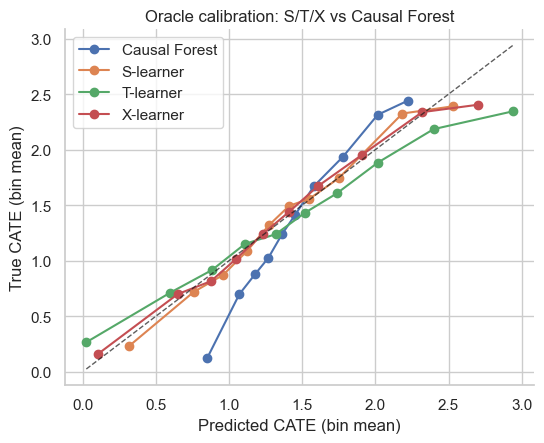

,Model,cal_slope,cal_intercept,cal_r
0,Causal Forest,1.694,-1.129,0.989
1,S-learner,1.029,-0.052,0.993
2,T-learner,0.753,0.279,0.994
3,X-learner,0.926,0.090,0.992


In [44]:
tau_s = s_learner_tau(train_df, test_df, FEATURES)
tau_t = t_learner_tau(train_df, test_df, FEATURES)
tau_xe = x_learner_econml_tau(train_df, test_df, FEATURES, base="rf")
tau_cf, _ = causal_forest_tau(train_df, test_df, FEATURES, base_y="rf")

cal_s  = make_calibration_df(test_df, tau_s,  q=10, label="S-learner")
cal_t  = make_calibration_df(test_df, tau_t,  q=10, label="T-learner")
cal_x  = make_calibration_df(test_df, tau_xe, q=10, label="X-learner")
cal_cf = make_calibration_df(test_df, tau_cf, q=10, label="Causal Forest")

cal_all = pd.concat([cal_s, cal_t, cal_x, cal_cf], ignore_index=True)
plot_oracle_calibration(cal_all, title="Oracle calibration: S/T/X vs Causal Forest")
display(calibration_summary(cal_all).round(3))

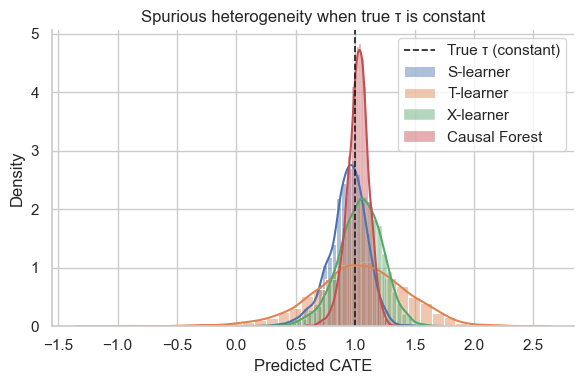

Std. dev. of predicted CATE — S-learner: 0.161
Std. dev. of predicted CATE — T-learner: 0.407
Std. dev. of predicted CATE — X-learner: 0.190
Std. dev. of predicted CATE — Causal Forest: 0.093
True τ variance: 0.000


In [47]:
def plot_spurious_when_constant_tau(test_df_c, tau_s_c, tau_t_c, tau_x_c=None, tau_cf_c=None, bins=40, title=None):
    preds = {"S-learner": tau_s_c, "T-learner": tau_t_c}
    if tau_x_c is not None: preds["X-learner"] = tau_x_c
    if tau_cf_c is not None: preds["Causal Forest"] = tau_cf_c
    fig, ax = plt.subplots(figsize=(6, 4))
    for name, tau in preds.items():
        sns.histplot(tau, bins=bins, kde=True, stat="density", label=name, alpha=0.45, ax=ax)
    true_tau = float(test_df_c["tau_true"].mean())
    ax.axvline(true_tau, color="k", linestyle="--", linewidth=1.2, label="True τ (constant)")
    ax.set_xlabel("Predicted CATE")
    ax.set_ylabel("Density")
    ax.set_title(title or "Spurious heterogeneity when true τ is constant")
    ax.legend()
    sns.despine()
    plt.tight_layout()
    plt.show()

# Summary
    for name, tau in preds.items():
        std = np.std(tau)
        print(f"Std. dev. of predicted CATE — {name}: {std:.3f}")
    print(f"True τ variance: 0.000")

# 1) Compute all four on the constant-τ slice (adjust train_df_c / FEATURES to your vars)
tau_s_c  = s_learner_tau(train_df_c, test_df_c, FEATURES)
tau_t_c  = t_learner_tau(train_df_c, test_df_c, FEATURES)
tau_x_c  = x_learner_econml_tau(train_df_c, test_df_c, FEATURES, base="rf")
tau_cf_c, _ = causal_forest_tau(train_df_c, test_df_c, FEATURES, base_y="rf")

# 2) Call with correct order (S, T, then optional X, CF)
plot_spurious_when_constant_tau(
    test_df_c,
    tau_s_c,
    tau_t_c,
    tau_x_c=tau_x_c,
    tau_cf_c=tau_cf_c
)

### Things to try!

Think!